In [1]:
# from google.colab import drive
import os,cv2, sys, math , csv
# drive.mount('/content/gdrive')

In [2]:
import numpy as np 
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from tensorflow.keras.applications import VGG19
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")
import albumentations as albu
import time
import os
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [5]:
base_image_dir = os.path.join('../input/eye-dataset/Eye_PACS', 'input', 'diabetic-retinopathy-detection')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'Train_labels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'train_512/'
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(10)

9204 images found of 34366 total


,Unnamed: 0,image,level,PatientId,path,exists,eye,level_cat
10168,10928,13743_left,0,13743,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
11030,11790,14805_left,0,14805,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
9012,9504,11962_left,2,11962,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
12959,13719,17209_right,0,17209,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
13407,14167,17792_right,0,17792,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
15584,16344,20477_left,0,20477,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
14661,15421,19314_right,0,19314,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
16211,16971,21280_right,0,21280,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
8848,9270,11647_left,2,11647,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
16404,17164,21546_left,0,21546,../input/eye-dataset/Eye_PACS/input/diabetic-r...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


array([[<AxesSubplot:title={'center':'level'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

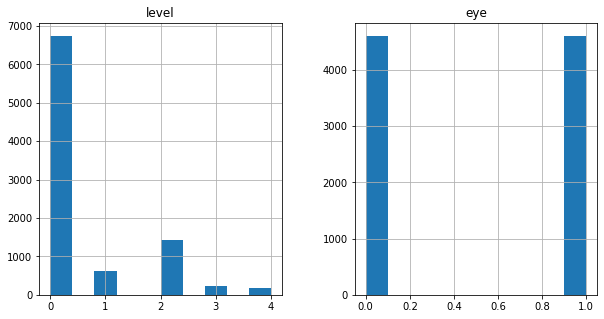

In [6]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [7]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
rr_df = valid_df[['PatientId', 'level']].drop_duplicates()
valid_ids, test_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
test_df = retina_df[retina_df['PatientId'].isin(test_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])

train 7082 validation 1366 test 1394


90    0
91    0
92    0
93    0
96    0
Name: level, dtype: int64
[0 1 2 3 4] [5118  520 1118  183  143]
[0.27732279 0.92657441 0.84213499 0.97415984 0.97980796]


<AxesSubplot:xlabel='level', ylabel='count'>

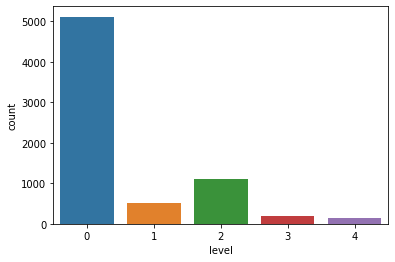

In [8]:
print(raw_train_df['level'].head())
(unique,counts) = np.unique(np.array(raw_train_df['level']),return_counts=True)
print(unique,counts)
weights = [0,0,0,0,0]
weights = (np.sum(counts) - counts) / np.sum(counts)
print(weights)
sns.countplot(raw_train_df['level'])

New Data Size: 7500 Old Size: 7082


array([[<AxesSubplot:title={'center':'level'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

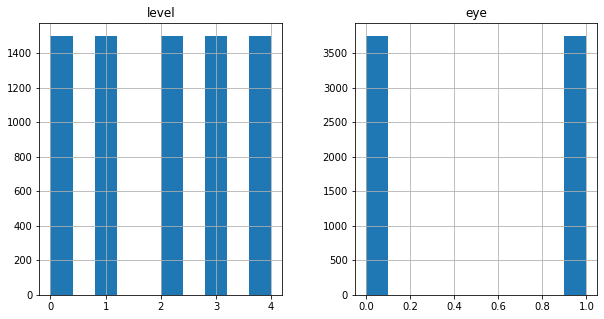

In [9]:
 train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(750, replace = True)).reset_index(drop = True)
 print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
 train_df[['level', 'eye']].hist(figsize = (10, 5))

In [10]:
transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.CropAndPad (percent = -0.2, keep_size=True, interpolation=cv2.INTER_NEAREST, p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit= 15, interpolation= cv2.INTER_NEAREST,
                                          border_mode= cv2.BORDER_REPLICATE, p=0.5)
])

In [11]:
def plot_result(img , title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i in range(4):
        print(img[i].shape)
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
    plt.show()

In [12]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, df,  batch_size=16, dim=(224,224,3), shuffle=True,transform=transform):
        'Initialization'
        self.dim = dim
        self.df = df
        #self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.df['path'][i] ,target_size=self.dim)
#             img = cv2.fastNlMeansDenoisingColored(img,None,20,20,7,21) 
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = self.df['level_cat'][i]
            batch_labels.append(label)

        return np.array(batch_imgs) ,np.array(batch_labels)

In [13]:
raw_train_df = raw_train_df.reset_index()
test_df = test_df.reset_index()
valid_df = valid_df.reset_index()

In [14]:
img_size = 512
#class_map = class_palette()

# train_generator1 = DataGenerator(raw_train_df,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_generator1 = DataGenerator(train_df,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
X,y = train_generator1.__getitem__(0)
print(y)
print(X.shape, y.shape)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(4, 512, 512, 3) (4, 5)


In [15]:
'''train_set = RetinalDataset(train_df)
val_set = RetinalDataset(valid_df)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) '''

'train_set = RetinalDataset(train_df)\nval_set = RetinalDataset(valid_df)\n\n#dataloader\nbatch_size= 4\n\ntrain_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) '

In [16]:
val_generator = DataGenerator(valid_df,  batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)

In [17]:
test_generator = DataGenerator(test_df,  batch_size=1, dim=(img_size,img_size,3) ,shuffle=False)

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# VGG19 Model

In [19]:
'''VGG16 model for Keras.
# Reference:
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
'''


from __future__ import print_function
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")
from keras import applications
from keras.applications import *
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax


In [20]:
# model = tf.keras.applications.ResNet50V2(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=(512,512,3),
#     pooling=None,
#     classes=5,
#     classifier_activation="softmax",
# )
# model.compile(loss="categorical_crossentropy",loss_weights = weights,optimizer="adam",metrics=["accuracy"])
# # model.summary()

In [21]:
# ini_input=keras.Input(shape=(512,512,3),name="image")

# x1=layers.Conv2D(64,(22,22),strides=2)(ini_input)
# x1=layers.MaxPooling2D((4,4))(x1)
# x1=layers.BatchNormalization()(x1)

# x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
# x2=layers.MaxPooling2D((2,2))(x2)
# x2=layers.BatchNormalization()(x2)

# x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
# x3=layers.MaxPooling2D((2,2))(x3)
# x3=layers.BatchNormalization()(x3)

# x4=layers.Flatten()(x3)
# x4=layers.Activation("relu")(x4)

# x5=layers.Dense(1024,"relu")(x4)

# x6=layers.Dense(256,"relu")(x5)

# x9=layers.Dense(5)(x6)
# pred=layers.Activation("softmax")(x9)

# model=keras.Model(inputs=ini_input,outputs=pred)

# model.compile(loss="categorical_crossentropy",loss_weights = weights,optimizer="adam",metrics=["accuracy"])
# model.summary()

In [22]:
# Initializing a Sequential model
model = Sequential()
# model.add(VGG19(input_shape=(512,512,3),include_top=False,weights='imagenet'))
model1 = tf.keras.applications.DenseNet169(input_shape=(512,512,3),include_top=False,weights='imagenet')
model1.trainable = False
model.add(model1)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Creating an output layer
model.add(Dense(units= 5, activation='softmax'))
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# Train the model with the new callback

# c3=tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="loss",
#     factor=0.1,
#     patience=2,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=0.001
# )
model.compile(optimizer='adam',loss='categorical_crossentropy',loss_weights = weights, metrics=['accuracy','AUC'])
model.summary()
# history=model.fit(train_generator1,epochs=10,batch_size=16,validation_data=val_generator)

2022-04-28 20:29:58.896759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 20:29:58.897893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 20:29:58.898576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 20:29:58.899351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 16, 16, 1664)      12642880  
_________________________________________________________________
flatten (Flatten)            (None, 425984)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 425984)            1703936   
_________________________________________________________________
dense (Dense)                (None, 64)                27263040  
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________

In [23]:
# history=model.fit(train_generator1,epochs=50,batch_size=4,validation_data=val_generator)

In [24]:
# img_shape=(512, 512, 3)
# model_name='EfficientNetB5'
# base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
# base_model.trainable= False
# x=base_model.output
# x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
# x=Dropout(rate=.3, seed=123)(x)
# x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
# x=Dropout(rate=.45, seed=123)(x)        
# output=Dense(5, activation='softmax')(x)
# model=Model(inputs=base_model.input, outputs=output)

# # for layer in model.layers[:]:
# #     print(layer.)
# lr=.001 # start with this learning rate
# model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy',loss_weights = weights, metrics=['accuracy']) 
# # model.summary()

In [25]:
history = model.fit(train_generator1,epochs=50,batch_size=4,validation_data=val_generator)

2022-04-28 20:30:09.478541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-28 20:30:18.493621: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1875/1875 [==============================] - 166s 81ms/step - loss: 1.1343 - accuracy: 0.4087 - auc: 0.7277 - val_loss: 0.9396 - val_accuracy: 0.4765 - val_auc: 0.8099
Epoch 2/50
1875/1875 [==============================] - 150s 80ms/step - loss: 0.8525 - accuracy: 0.5519 - auc: 0.8512 - val_loss: 0.8668 - val_accuracy: 0.4846 - val_auc: 0.8345
Epoch 3/50
1875/1875 [==============================] - 150s 80ms/step - loss: 0.7574 - accuracy: 0.6161 - auc: 0.8845 - val_loss: 0.7990 - val_accuracy: 0.5630 - val_auc: 0.8667
Epoch 4/50
1875/1875 [==============================] - 151s 80ms/step - loss: 0.6904 - accuracy: 0.6509 - auc: 0.9050 - val_loss: 0.7556 - val_accuracy: 0.5968 - val_auc: 0.8825
Epoch 5/50
1875/1875 [==============================] - 155s 83ms/step - loss: 0.6247 - accuracy: 0.6960 - auc: 0.9231 - val_loss: 0.7509 - val_accuracy: 0.5858 - val_auc: 0.8810
Epoch 6/50
1875/1875 [==============================] - 151s 80ms/step - loss: 0.5516 - accuracy: 0.7329 - auc: 0.93

In [26]:
model.save('.//weights.h5')

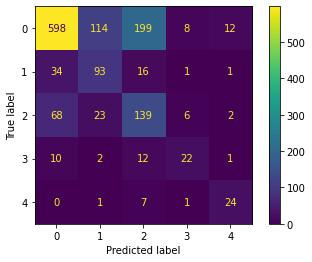

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
Y_test=test_df['level']
pred=np.argmax(model.predict(test_generator),axis=-1)
cm=confusion_matrix(Y_test,pred)
cm_plot=ConfusionMatrixDisplay(cm,display_labels=['0','1','2','3','4'])
cm_plot.plot()
plt.show()

In [28]:
print("Performance Report:")
y_pred6=np.argmax(model.predict(test_generator),axis=-1)

y_pred_prb6=model.predict(test_generator)
target=['0','1','2','3','4']
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(Y_test, y_pred6))
print('Precision score is :', metrics.precision_score(Y_test, y_pred6, average='weighted'))
print('Recall score is :',metrics.recall_score(Y_test,y_pred6, average='weighted'))
print('F1 Score is :', metrics.f1_score(Y_test, y_pred6,average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(Y_test, y_pred6))
print('\t\tClassification Report:\n', metrics.classification_report(Y_test,pred,target_names=target))

Performance Report:
Accuracy score is : 0.6284074605451937
Precision score is : 0.7013743041417024
Recall score is : 0.6284074605451937
F1 Score is : 0.6486372598522605
Cohen Kappa Score: 0.37565593168021394
		Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.64      0.73       931
           1       0.40      0.64      0.49       145
           2       0.37      0.58      0.45       238
           3       0.58      0.47      0.52        47
           4       0.60      0.73      0.66        33

    accuracy                           0.63      1394
   macro avg       0.56      0.61      0.57      1394
weighted avg       0.70      0.63      0.65      1394



In [29]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='train', marker='o')
    plt.plot( history.history['val_accuracy'], label='val', marker='o')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss', marker='*')
    plt.plot(history.history['val_loss'], label='val_loss',  marker='*')
    plt.title('Loss per epoch'); plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

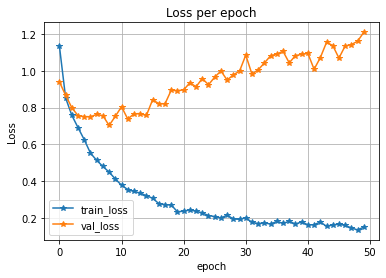

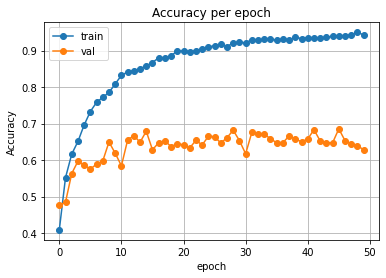

In [30]:
plot_loss(history)
plot_acc(history)

In [31]:
# plt.title("Test Image")
# plt.imshow(x_test[1])
# plt.show()
# x_test1 = x_test[1]
# x_test1 = x_test1[np.newaxis,...]
# y_test3=np.argmax(y_test[1], axis=-1)
# pred=np.argmax(model.predict(x_test1),axis=-1)
# print("Level=", pred)

In [32]:
# np.argmax(y_val,axis=-1)